# Importing the relevant libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# Data Preprocessing

In [2]:
# Load the data into a pandas DataFrame
file_path = 'ml_datasource.csv'
raw_data = pd.read_csv(file_path)

# Display the first five records in the DataFrame using the head method
print(raw_data.head())

  student_country  days_on_platform  minutes_watched  courses_started  \
0              US               288            358.1                1   
1              SG               260              1.7                1   
2              TR               260             22.4                1   
3              KE               259             18.8                1   
4              IN               259            118.0                2   

   practice_exams_started  practice_exams_passed  minutes_spent_on_exams  \
0                       2                      2                   15.81   
1                       1                      0                   16.00   
2                       1                      0                    0.93   
3                       1                      1                   14.63   
4                       2                      1                   16.48   

   purchased  
0          0  
1          0  
2          0  
3          0  
4          0  


In [3]:
# Copy the raw data to a new variable called 'data'
data = raw_data.copy()

In [4]:
# Check info and datatypes of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17761 entries, 0 to 17760
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   student_country         17752 non-null  object 
 1   days_on_platform        17761 non-null  int64  
 2   minutes_watched         17761 non-null  float64
 3   courses_started         17761 non-null  int64  
 4   practice_exams_started  17761 non-null  int64  
 5   practice_exams_passed   17761 non-null  int64  
 6   minutes_spent_on_exams  17761 non-null  float64
 7   purchased               17761 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
# Check how many null values are there
data.isnull().sum()

student_country           9
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_started    0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64

In [6]:
# Check for duplicates
data.duplicated().sum()

575

Since there is no unique id, we can't assume that they are duplicated values, but rather same entries and thus we won't drop them.

# Removing Outliers

Plot the columns we are interested in, with the original data and then with the removal of the outliers.

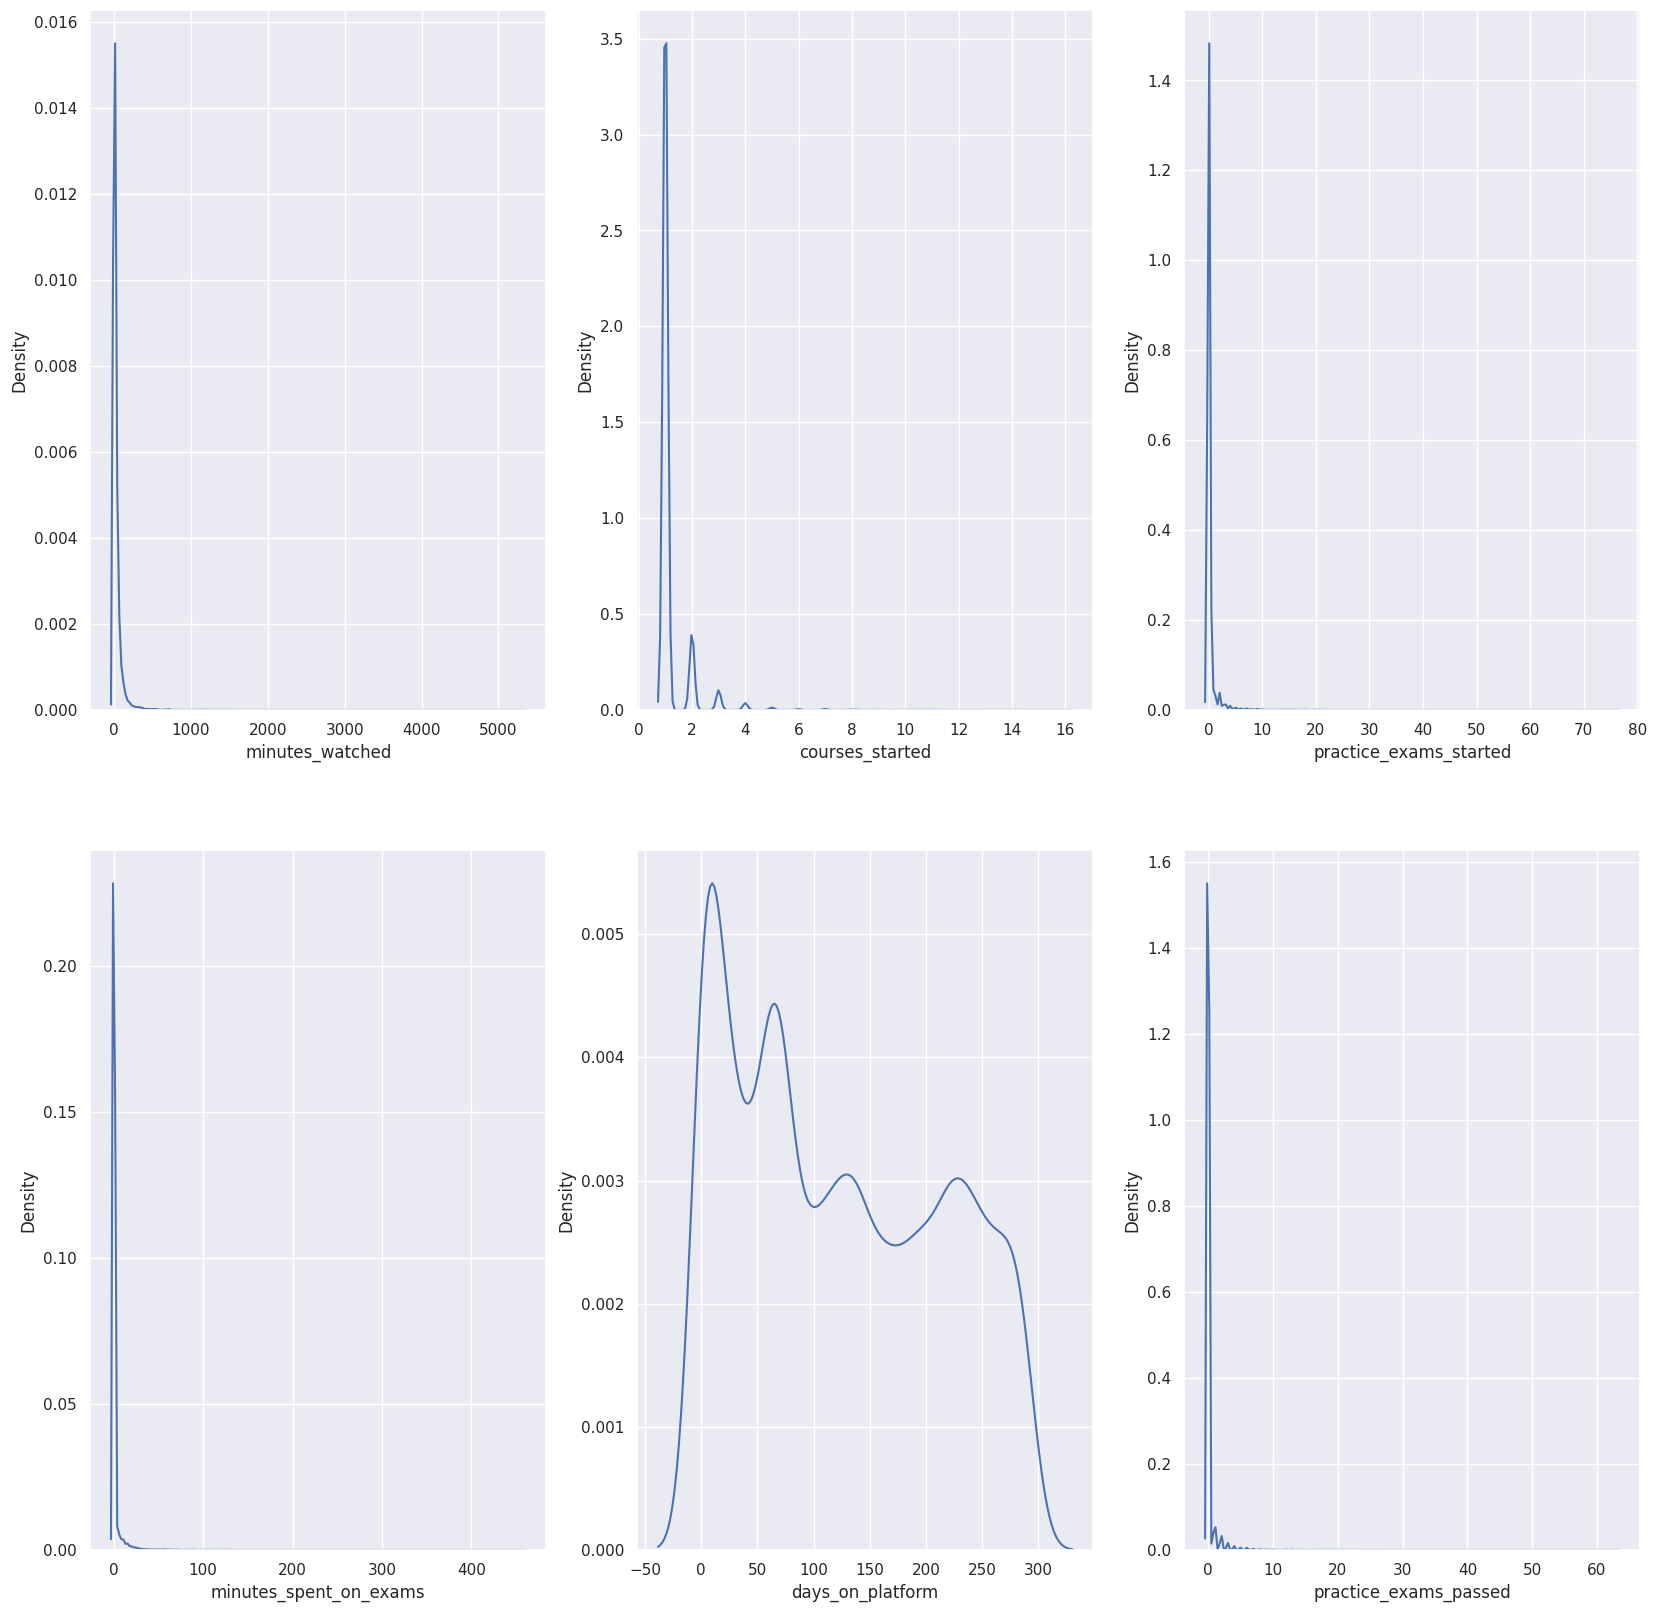

In [7]:
# Create distribution plots for numerical features
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

# Distribution plots using seaborn's kdeplot
sns.kdeplot(data=data['minutes_watched'], ax=axes[0, 0])
sns.kdeplot(data=data['courses_started'], ax=axes[0, 1])
sns.kdeplot(data=data['practice_exams_started'], ax=axes[0, 2])
sns.kdeplot(data=data['minutes_spent_on_exams'], ax=axes[1, 0])
sns.kdeplot(data=data['days_on_platform'], ax=axes[1, 1])
sns.kdeplot(data=data['practice_exams_passed'], ax=axes[1, 2])
plt.show()

Remove data points from the DataFrame that meet the following criteria:

- Minutes watched larger than 1,000
- Number of courses surpassing 10
- Number of practice exams started higher than 10
- Minutes spent on exams going beyond 40 minutes.

In [8]:
# Remove outliers and create a new DataFrame (data_no_outliers)
data_no_outliers = data[
    (data['minutes_watched'] <= 1000) &
    (data['courses_started'] <= 10) &
    (data['practice_exams_started'] <= 10) &
    (data['minutes_spent_on_exams'] <= 40)
]

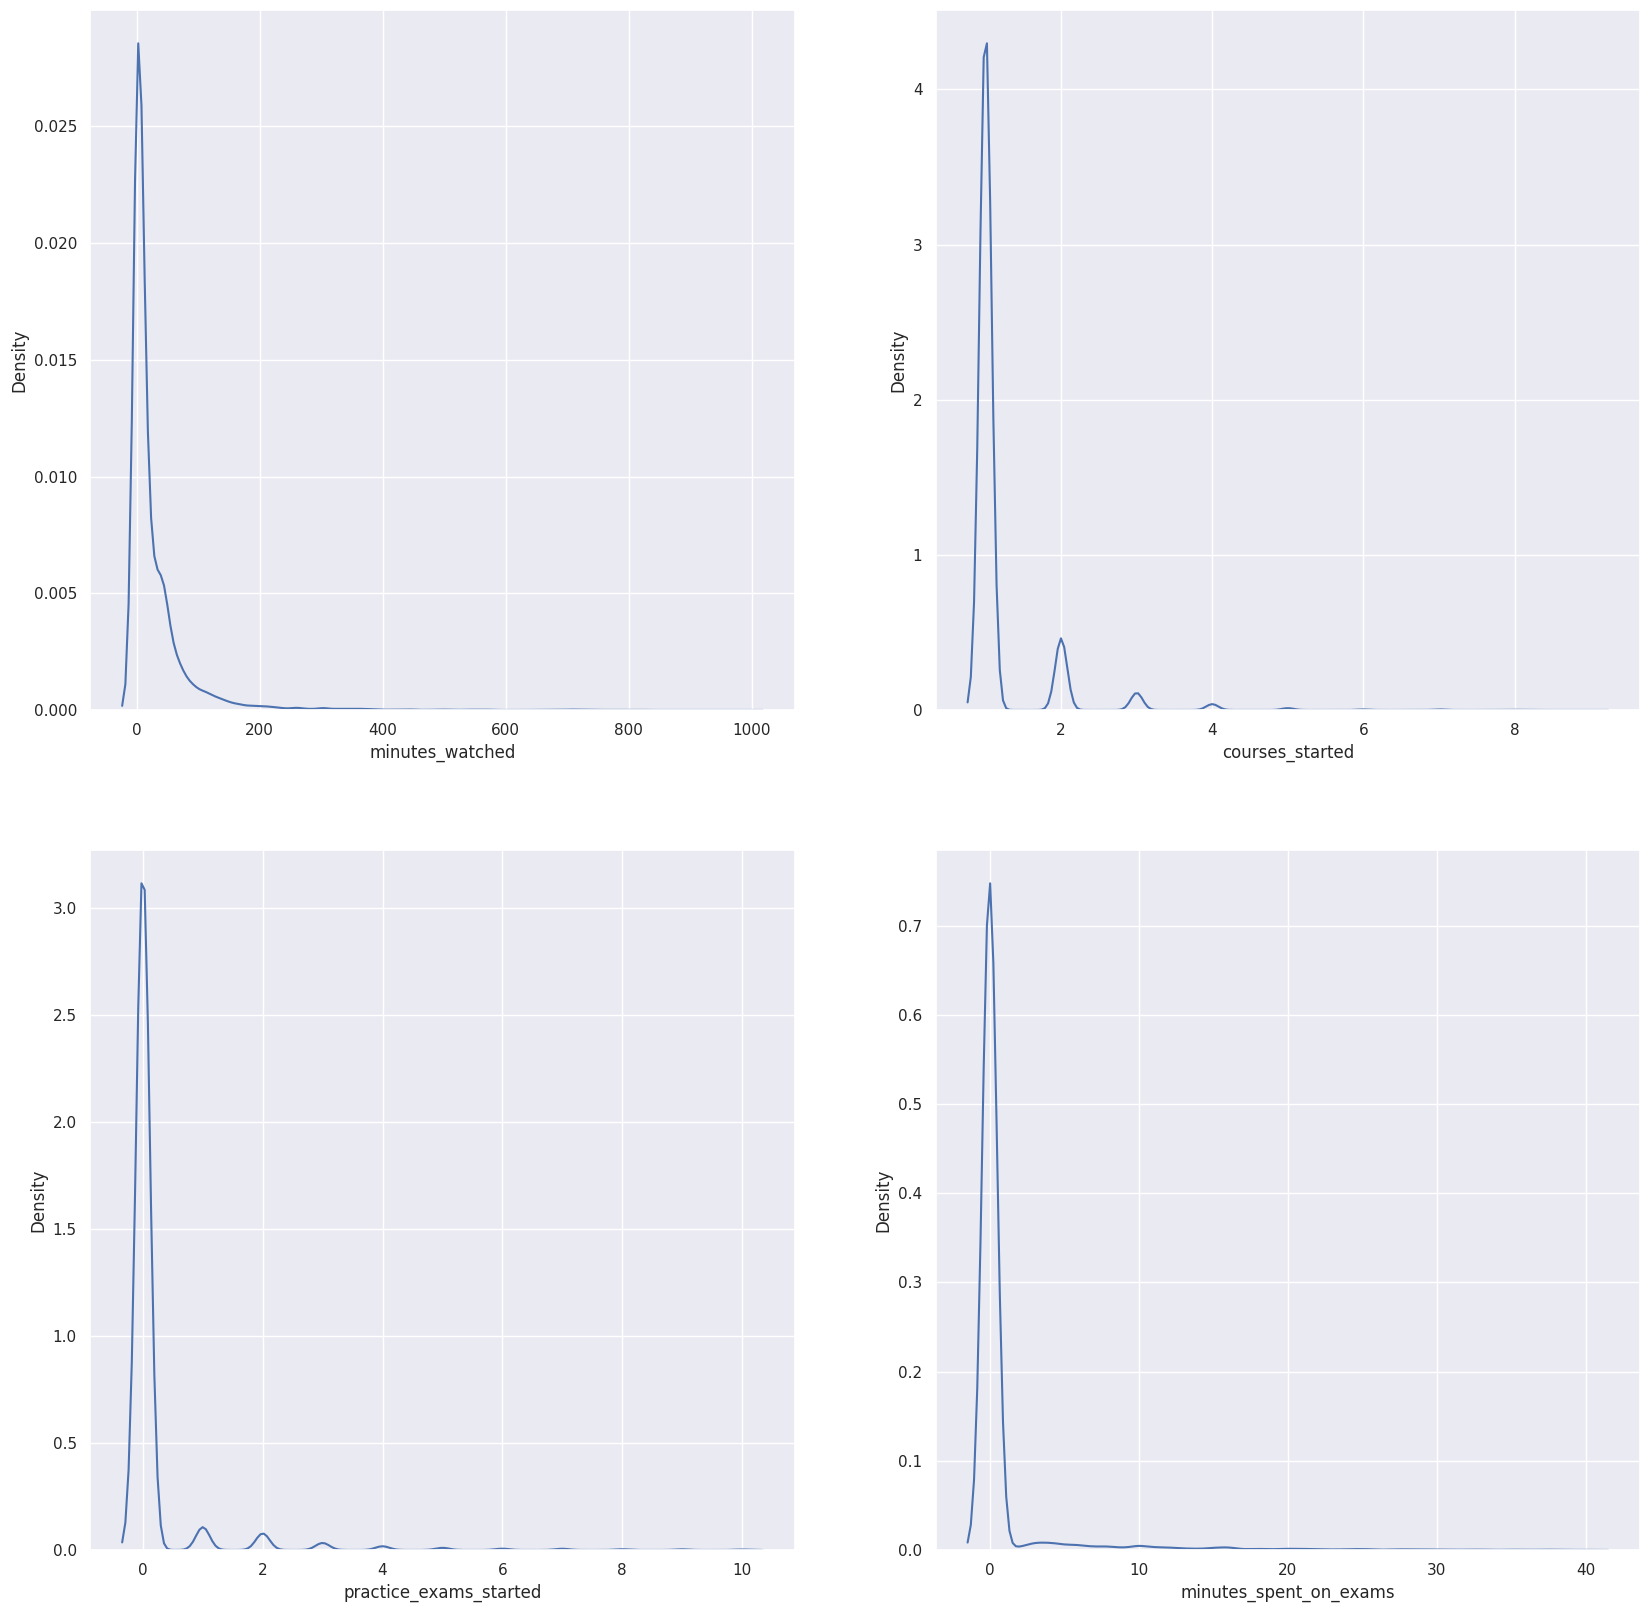

In [9]:
# Create distribution plots for numerical features
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Create distribution plots for numerical features without outliers
sns.kdeplot(data=data_no_outliers['minutes_watched'], ax=axes[0, 0])
sns.kdeplot(data=data_no_outliers['courses_started'], ax=axes[0, 1])
sns.kdeplot(data=data_no_outliers['practice_exams_started'], ax=axes[1, 0])
sns.kdeplot(data=data_no_outliers['minutes_spent_on_exams'], ax=axes[1, 1])

# Display the plots
plt.show()

## Check for multicollinearity using the Variance Inflation Factor (VIF)

In [10]:
# Create a function to calculate VIF for all features
def calculate_vif(data_frame):
    numeric_data = data_frame.select_dtypes(include=['float64', 'int64'])
    variables = numeric_data.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
    return vif_data

# Print out initial VIF values
initial_vif = calculate_vif(data_no_outliers)
print("Initial VIF Values:")
print(initial_vif)

Initial VIF Values:
                 Variable        VIF
0        days_on_platform   2.494163
1         minutes_watched   1.814420
2         courses_started   3.504408
3  practice_exams_started  10.206234
4   practice_exams_passed   7.829732
5  minutes_spent_on_exams   3.355225
6               purchased   1.229006


In [11]:
# Remove the feature with the highest VIF value (> 5)
while initial_vif['VIF'].max() > 5:
    feature_to_remove = initial_vif.loc[initial_vif['VIF'].idxmax(), 'Variable']
    print(f"Removing feature with high VIF: {feature_to_remove}")
    data_no_outliers = data_no_outliers.drop(feature_to_remove, axis=1)
    initial_vif = calculate_vif(data_no_outliers)

# Store the result in a new DataFrame
data_no_mult = data_no_outliers.copy()

# Print out final VIF values
final_vif = calculate_vif(data_no_mult)
print("Final VIF Values:")
print(final_vif)

Removing feature with high VIF: practice_exams_started
Final VIF Values:
                 Variable       VIF
0        days_on_platform  2.492125
1         minutes_watched  1.813759
2         courses_started  3.498304
3   practice_exams_passed  2.569373
4  minutes_spent_on_exams  2.616566
5               purchased  1.228475


## Dealing with NaN Values

When checking the csv manually to identify the NaN values, it turns out the string NA in database refers to the country code of Namibia. But after importing the CSV file into a pandas DataFrame, this country code has been translated to NaN. We will substitute all NaN values in the student_country column with the string 'NAM'.

In [12]:
# Print the records with NaN values in the student_country column
nan_records = data.loc[data['student_country'].isna()]
print("Records with NaN values in student_country:")
print(nan_records)

Records with NaN values in student_country:
      student_country  days_on_platform  minutes_watched  courses_started  \
311               NaN                88             58.1                1   
337               NaN                86             43.0                1   
526               NaN                70            801.2                3   
556               NaN               121            241.9                2   
806               NaN                64             86.4                1   
1097              NaN                72             67.5                1   
12363             NaN                84              6.2                1   
12633             NaN                78              3.0                1   
16946             NaN                11              8.2                1   

       practice_exams_started  practice_exams_passed  minutes_spent_on_exams  \
311                         2                      2                   11.20   
337                      

In [13]:
# Use the fillna method to replace NaN values in the student_country column
data_no_nulls = data_no_mult.fillna(value={'student_country': 'NAM'}, inplace=False)

# Confirm there are no NaN values left in the DataFrame
print("NaN Values After Replacement:")
print(data_no_nulls.isnull().sum())

NaN Values After Replacement:
student_country           0
days_on_platform          0
minutes_watched           0
courses_started           0
practice_exams_passed     0
minutes_spent_on_exams    0
purchased                 0
dtype: int64


## Splitting the Data

In [14]:
# Create inputs and target variables
X = data_no_nulls.drop('purchased', axis=1)  # Inputs
y = data_no_nulls['purchased']  # Target variable

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=365, stratify=y)

# Step 4: Check the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (14100, 6)
Shape of X_test: (3526, 6)
Shape of y_train: (14100,)
Shape of y_test: (3526,)


## Encoding the Data

We must store all features as numerical values. We should therefore deal with the student_country column storing values of a string data type. We modify the OrdinalEncoder instance to assign a chosen value to all country codes that are not present in the training data, but present in the test data. The maximum encoded value in the training data is 165 — so 170 is a good choice.

In [16]:
# Initialize OrdinalEncoder with specified parameters
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=170)

# Fit and transform the 'student_country' column in the training data
X_train['student_country_enc'] = enc.fit_transform(X_train['student_country'].to_numpy().reshape(-1, 1))

# Transform the 'student_country' column in the test data
X_test['student_country_enc'] = enc.transform(X_test['student_country'].to_numpy().reshape(-1, 1))

# Drop the original 'student_country' column from both training and testing datasets
X_train = X_train.drop('student_country', axis=1)
X_test = X_test.drop('student_country', axis=1)

# Convert pandas objects to numpy ndarrays
X_train_array = np.asarray(X_train, dtype='float')
y_train_array = np.asarray(y_train, dtype='int')
X_test_array = np.asarray(X_test, dtype='float')
y_test_array = np.asarray(y_test, dtype='int')

In [17]:
# Display the first few records in the transformed datasets
print("Transformed Training Data:")
print(X_train.head())
print("\nTransformed Testing Data:")
print(X_test.head())

Transformed Training Data:
       days_on_platform  minutes_watched  courses_started  \
5718                218              1.6                2   
3119                263             75.5                1   
5440                222             44.4                1   
11828                97              2.6                1   
8454                162              1.0                1   

       practice_exams_passed  minutes_spent_on_exams  student_country_enc  
5718                       0                     0.0                 69.0  
3119                       0                     0.0                 69.0  
5440                       0                     0.0                 84.0  
11828                      0                     0.0                148.0  
8454                       0                     0.0                 80.0  

Transformed Testing Data:
       days_on_platform  minutes_watched  courses_started  \
2018                284              0.7                1   
1

# Creating a Logistic Regression Model

In [18]:
# Set up logistic regression model
log_reg = sm.Logit(y_train_array, sm.add_constant(X_train_array))

# Fit the logistic regression model
log_reg_results = log_reg.fit()

# Display the summary of the logistic regression model
print(log_reg_results.summary())

Optimization terminated successfully.
         Current function value: 0.150289
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14100
Model:                          Logit   Df Residuals:                    14093
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Dec 2023   Pseudo R-squ.:                  0.5111
Time:                        17:32:27   Log-Likelihood:                -2119.1
converged:                       True   LL-Null:                       -4334.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0543      0.118     -8.961      0.000      -1.285      -0.824
x1            -0.0666      0

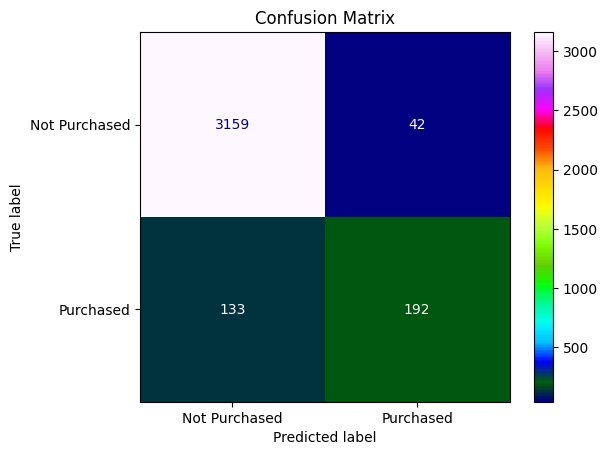

In [19]:
sns.reset_orig()

# Make predictions on the test data
y_pred_prob = log_reg_results.predict(sm.add_constant(X_test_array))
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to 0 or 1 based on the threshold of 0.5

# Display the confusion matrix
cm = confusion_matrix(y_test_array, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Purchased', 'Purchased'])
cm_display.plot(cmap='gist_ncar', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Display the predictions and actual values
predictions_df = pd.DataFrame({'Actual': y_test_array, 'Predicted': y_pred})
print("\nPredictions vs Actual Values:")
print(predictions_df)


Predictions vs Actual Values:
      Actual  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
...      ...        ...
3521       0          0
3522       0          0
3523       0          0
3524       0          0
3525       0          0

[3526 rows x 2 columns]


# Creating a K-Nearest Neighbors Model

In [21]:
# Define the range of parameters for tuning
parameters_knn = {
    'n_neighbors': range(1, 51),
    'weights': ['uniform', 'distance']
}

# Create an instance of GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=parameters_knn,
    scoring='accuracy',
    cv=5
)

# Fit the grid_search_knn object to the training data
grid_search_knn.fit(X_train_array, y_train_array)

# Get the best KNN model from the grid search
knn_clf = grid_search_knn.best_estimator_

# Make predictions on the test data
y_test_pred_knn = knn_clf.predict(X_test_array)

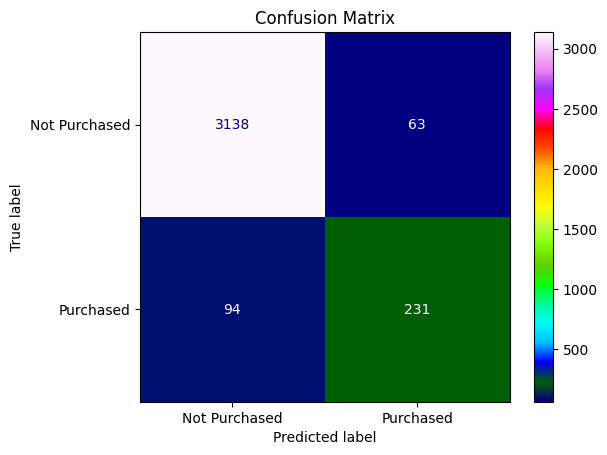

In [22]:
sns.reset_orig()

# Build and display the confusion matrix
cm_knn = confusion_matrix(y_test_array, y_test_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Not Purchased', 'Purchased'])
cm_display_knn.plot(cmap='gist_ncar', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Print the classification report
class_names = ['Not Purchased', 'Purchased']
classification_rep = classification_report(y_test_array, y_test_pred_knn, target_names=class_names)
print("Classification Report:")
print(classification_rep)

Classification Report:
               precision    recall  f1-score   support

Not Purchased       0.97      0.98      0.98      3201
    Purchased       0.79      0.71      0.75       325

     accuracy                           0.96      3526
    macro avg       0.88      0.85      0.86      3526
 weighted avg       0.95      0.96      0.95      3526



# Creating a Support Vector Machine Model

In [24]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the training data with MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train_array)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test_array)

In [25]:
# Define the range of parameters for tuning the SVM model
parameters_svm = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': range(1, 11),
    'gamma': ['scale', 'auto']
}

# Create an instance of GridSearchCV for SVM
grid_search_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=parameters_svm,
    scoring='accuracy',
    cv=5
)

# Fit the grid_search_svm object to the scaled training data
grid_search_svm.fit(X_train_scaled, y_train_array)

# Get the best SVM model from the grid search
svm_clf = grid_search_svm.best_estimator_

# Make predictions on the scaled test data
y_test_pred_svm = svm_clf.predict(X_test_scaled)

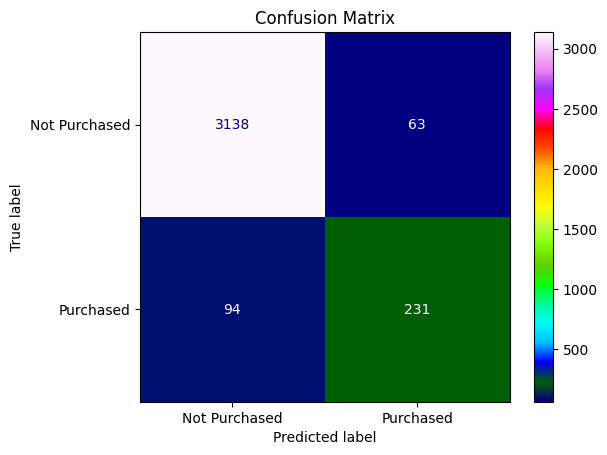

In [26]:
sns.reset_orig()

# Build and display the confusion matrix
cm_svm = confusion_matrix(y_test_array, y_test_pred_svm)
cm_display_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['Not Purchased', 'Purchased'])
cm_display_knn.plot(cmap='gist_ncar', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Print the classification report
classification_rep_svm = classification_report(y_test_array, y_test_pred_svm, target_names=class_names)
print("Classification Report (SVM):")
print(classification_rep_svm)

Classification Report (SVM):
               precision    recall  f1-score   support

Not Purchased       0.97      0.98      0.98      3201
    Purchased       0.81      0.68      0.74       325

     accuracy                           0.96      3526
    macro avg       0.89      0.83      0.86      3526
 weighted avg       0.95      0.96      0.95      3526



# Creating a Decision Trees Model

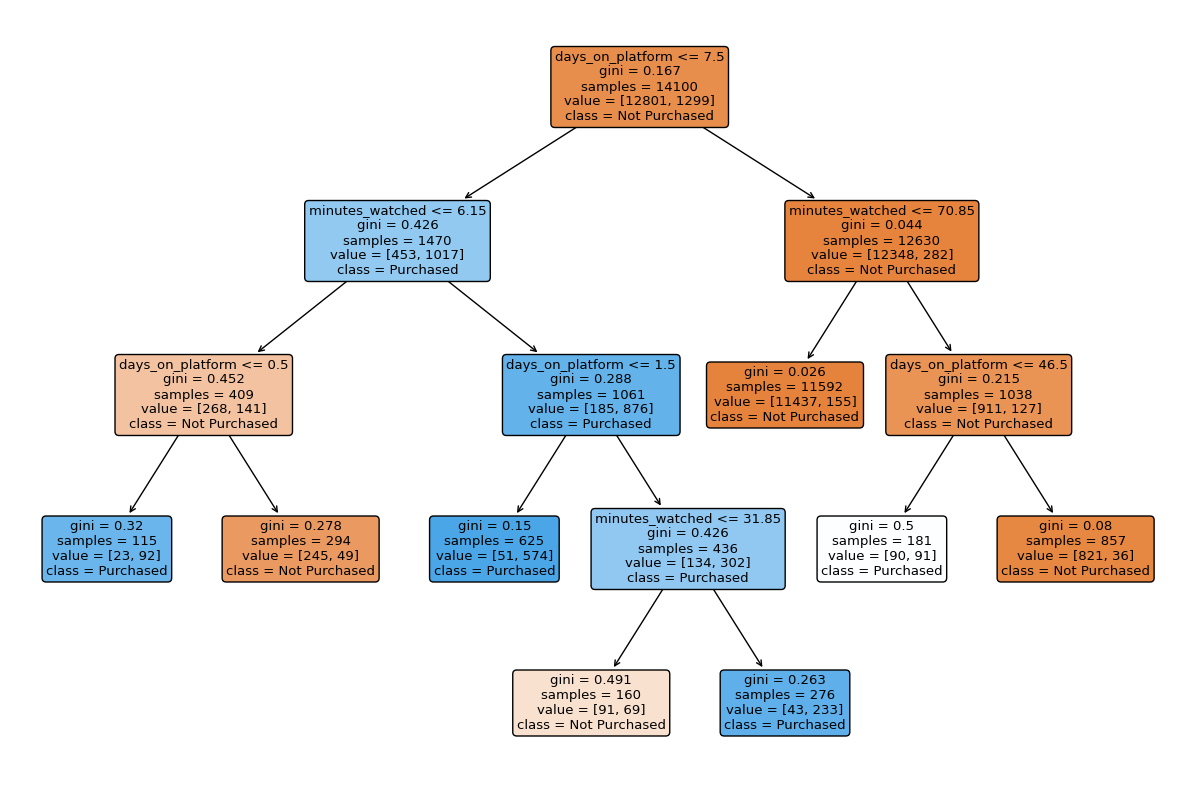

In [28]:
# Define the range of parameters for tuning the Decision Tree model
parameters_dt = {
    'ccp_alpha': [0, 0.001, 0.002, 0.003, 0.004, 0.005]
}

# Create an instance of GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=365),
    param_grid=parameters_dt,
    scoring='accuracy',
    cv=5
)

# Fit the grid_search_dt object to the non-scaled training data
grid_search_dt.fit(X_train_array, y_train_array)

# Get the best Decision Tree model from the grid search
dt_clf = grid_search_dt.best_estimator_

# Display the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_clf, filled=True, feature_names=X_train.columns, class_names=['Not Purchased', 'Purchased'], rounded=True)
plt.show()

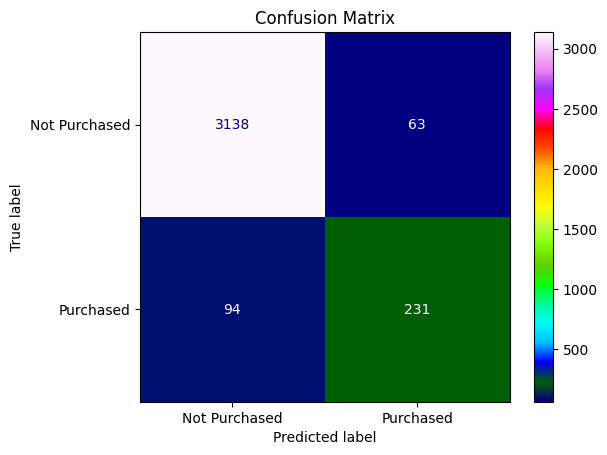

In [29]:
sns.reset_orig()

# Make predictions on the non-scaled test data
y_test_pred_dt = dt_clf.predict(X_test_array)

# Build and display the confusion matrix
cm_dt = confusion_matrix(y_test_array, y_test_pred_dt)
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Not Purchased', 'Purchased'])
cm_display_knn.plot(cmap='gist_ncar', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Print the classification report
classification_rep_dt = classification_report(y_test_array, y_test_pred_dt, target_names=class_names)
print("Classification Report (Decision Tree):")
print(classification_rep_dt)

Classification Report (Decision Tree):
               precision    recall  f1-score   support

Not Purchased       0.98      0.98      0.98      3201
    Purchased       0.81      0.76      0.78       325

     accuracy                           0.96      3526
    macro avg       0.90      0.87      0.88      3526
 weighted avg       0.96      0.96      0.96      3526



# Creating a Random Forests Model

In [31]:
# Create an instance of RandomForestClassifier with the best ccp_alpha value
rf_clf = RandomForestClassifier(ccp_alpha=grid_search_dt.best_params_['ccp_alpha'], random_state=365)

# Fit the Random Forest model using the training data
rf_clf.fit(X_train_array, y_train_array)

# Make predictions on the test data
y_test_pred_rf = rf_clf.predict(X_test_array)

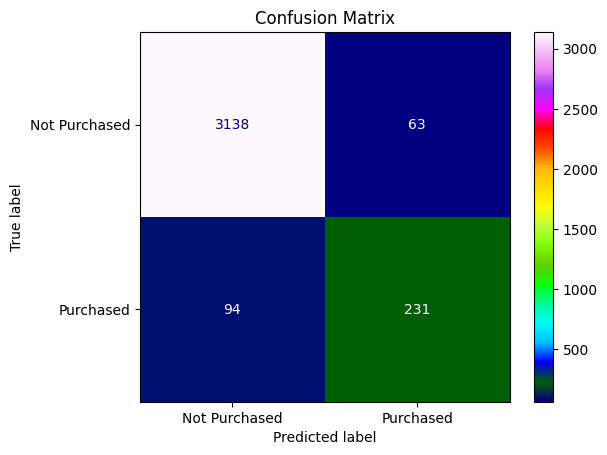

In [32]:
sns.reset_orig()

# Display the confusion matrix
cm_rf = confusion_matrix(y_test_array, y_test_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not Purchased', 'Purchased'])
cm_display_knn.plot(cmap='gist_ncar', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Print the classification report
classification_rep_rf = classification_report(y_test_array, y_test_pred_rf, target_names=class_names)
print("Classification Report (Random Forest):")
print(classification_rep_rf)

Classification Report (Random Forest):
               precision    recall  f1-score   support

Not Purchased       0.97      0.98      0.98      3201
    Purchased       0.83      0.75      0.79       325

     accuracy                           0.96      3526
    macro avg       0.90      0.87      0.88      3526
 weighted avg       0.96      0.96      0.96      3526

